In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans


pd.set_option('display.max_columns', 500)

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.sample(10)

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
10906,C-13578,Lacey Palazzo,F,62,3660.59,Low,Working,High skill tech staff,Rural,21009.21,156.00,Y,Y,5.0,738.62,1,Inactive,824,3660.59,1,Urban,1,27668.28,13655.99
22988,C-43684,Palma Alameda,F,20,2783.57,Low,Working,Laborers,Semi-Urban,94821.77,306.45,Y,Y,2.0,649.92,1,Active,823,2783.57,3,Rural,1,108985.08,0.00
3719,C-45956,Nikki Mund,F,21,1536.94,Low,Commercial associate,NaN,Urban,123502.70,946.37,N,N,6.0,728.74,0,Unpossessed,379,1536.94,1,Rural,1,154682.12,0.00
8210,C-12848,Aleta Gessner,M,29,2663.44,Low,Working,Drivers,Rural,80673.05,682.42,Y,Y,2.0,689.87,0,Unpossessed,634,2663.44,2,Rural,1,121222.50,56471.14
18288,C-47122,Gay Dewolf,F,56,1645.52,Low,Commercial associate,NaN,Semi-Urban,85252.22,282.26,N,Y,1.0,877.49,1,Inactive,34,1645.52,1,Semi-Urban,0,141042.20,72464.39
23457,C-29183,Walter Leisy,F,56,NaN,Low,Working,IT staff,Semi-Urban,203834.98,810.44,N,Y,3.0,804.48,0,Inactive,188,NaN,3,Semi-Urban,1,229921.34,163067.98
11074,C-38454,Fumiko Kleven,M,41,2826.46,Low,Working,NaN,Semi-Urban,127862.42,808.76,Y,Y,2.0,731.32,0,Inactive,497,2826.46,1,Semi-Urban,1,157364.59,83110.57
24465,C-11082,Antonio Mulvihill,F,18,3872.56,Low,Working,Laborers,Semi-Urban,77245.69,483.31,N,Y,2.0,618.18,0,Inactive,160,3872.56,1,Urban,0,132542.84,0.00
8298,C-37018,Rod Dewar,F,29,2121.95,Low,Commercial associate,NaN,Semi-Urban,93562.92,441.49,N,Y,3.0,616.69,0,Unpossessed,974,2121.95,4,Urban,1,133063.81,0.00
7815,C-8136,Donya Ankrom,F,43,2107.25,Low,Working,Drivers,Semi-Urban,39790.40,287.18,Y,Y,4.0,711.31,0,Active,969,2107.25,4,Semi-Urban,1,44861.93,27853.28


In [4]:
train.isnull().sum(), train.shape

(Customer ID                       0
 Name                              0
 Gender                           53
 Age                               0
 Income (USD)                   4576
 Income Stability               1683
 Profession                        0
 Type of Employment             7270
 Location                          0
 Loan Amount Request (USD)         0
 Current Loan Expenses (USD)     172
 Expense Type 1                    0
 Expense Type 2                    0
 Dependents                     2493
 Credit Score                   1703
 No. of Defaults                   0
 Has Active Credit Card         1566
 Property ID                       0
 Property Age                   4850
 Property Type                     0
 Property Location               356
 Co-Applicant                      0
 Property Price                    0
 Loan Sanction Amount (USD)      340
 dtype: int64,
 (30000, 24))

In [5]:
train.nunique()

Customer ID                    30000
Name                           30000
Gender                             2
Age                               48
Income (USD)                   24429
Income Stability                   2
Profession                         8
Type of Employment                18
Location                           3
Loan Amount Request (USD)      29982
Current Loan Expenses (USD)    24041
Expense Type 1                     2
Expense Type 2                     2
Dependents                        10
Credit Score                   17586
No. of Defaults                    2
Has Active Credit Card             3
Property ID                      999
Property Age                   24179
Property Type                      4
Property Location                  3
Co-Applicant                       3
Property Price                 29632
Loan Sanction Amount (USD)     21450
dtype: int64

<AxesSubplot:>

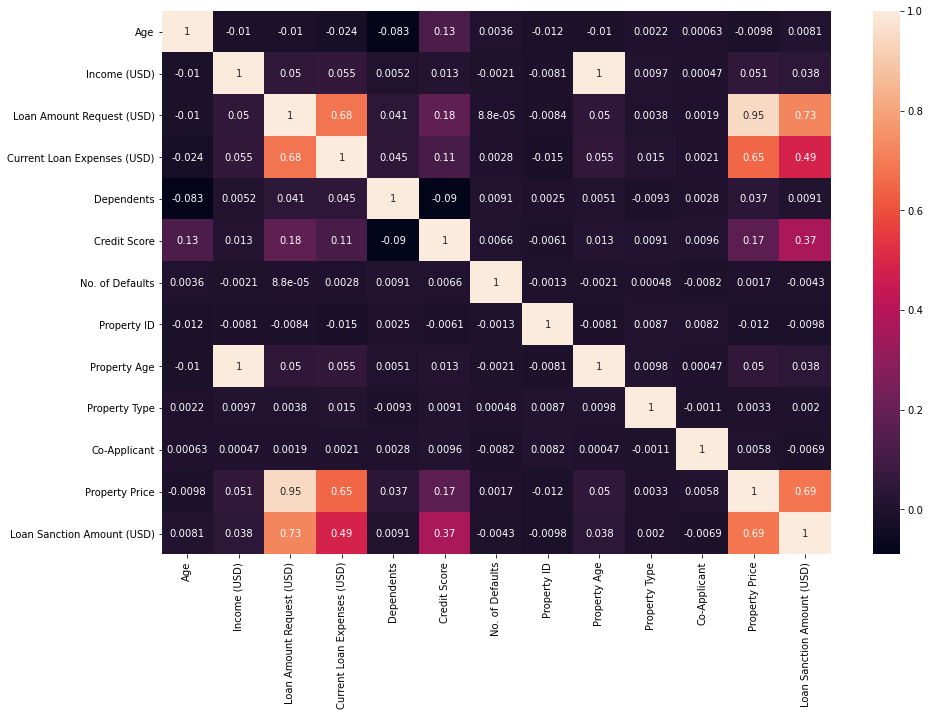

In [6]:
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(), annot=True)

In [7]:
#train['Loan Sanction Amount (USD)'].fillna(value=train['Loan Sanction Amount (USD)'].median(), inplace=True, axis=0)

In [8]:
train.dropna(axis=0, subset=['Loan Sanction Amount (USD)'], inplace=True, how='any')

In [9]:
train['Loan Sanction Amount (USD)'] = np.where(train['Loan Sanction Amount (USD)'] <0.0, 0.0,train['Loan Sanction Amount (USD)'])

In [10]:
train.Dependents.fillna(value=0, inplace=True, axis=0)

In [11]:
train.Gender.fillna(value='F', inplace= True, axis= 0)
test.Gender.fillna(value='F', inplace= True, axis= 0)

In [12]:
gend1 = pd.get_dummies(train.Gender, drop_first=True)
train = train.drop('Gender', axis= 1)
train = pd.concat([train, gend1], axis= 1)

In [13]:
gend2 = pd.get_dummies(test.Gender, drop_first=True)
test = test.drop('Gender', axis= 1)
test = pd.concat([test, gend2], axis= 1)

In [14]:
train['Income Stability'].fillna(value='High', inplace=True, axis=0)
test['Income Stability'].fillna(value='High', inplace=True, axis=0)

In [15]:
stab1 = pd.get_dummies(train['Income Stability'], drop_first=True)
train = train.drop('Income Stability', axis= 1)
train = pd.concat([train, stab1], axis= 1)

In [16]:
stab2 = pd.get_dummies(test['Income Stability'], drop_first=True)
test = test.drop('Income Stability', axis= 1)
test = pd.concat([test, stab2], axis= 1)

In [17]:
prof1 = pd.get_dummies(train.Profession, drop_first=True)
train = train.drop('Profession', axis= 1)
train = pd.concat([train, prof1], axis= 1)

In [18]:
prof2 = pd.get_dummies(test.Profession, drop_first=True)
test = test.drop('Profession', axis= 1)
test = pd.concat([test, prof2], axis= 1)

In [19]:
emp1 = pd.get_dummies(train['Type of Employment'], drop_first=True)
train = train.drop('Type of Employment', axis= 1)
train = pd.concat([train, emp1], axis= 1)

In [20]:
emp2 = pd.get_dummies(test['Type of Employment'], drop_first=True)
test = test.drop('Type of Employment', axis= 1)
test = pd.concat([test, emp2], axis= 1)

In [21]:
test['Co-Applicant'] = test['Co-Applicant'].astype(str).replace('?', np.nan)
test['Property Price'] = test['Property Price'].astype(str).replace('?', np.nan)

In [22]:
test['Co-Applicant']= test['Co-Applicant'].astype(float)
test['Property Price'] = test['Property Price'].astype(float)

In [24]:
train['Co-Applicant'].fillna(value= -999, inplace= True, axis= 0)
test['Co-Applicant'].fillna(value= -999, inplace= True, axis= 0)

In [25]:
train.Location.unique()

array(['Semi-Urban', 'Rural', 'Urban'], dtype=object)

In [26]:
train.Location = train.Location.map({'Rural': 0,
                                     'Semi-Urban':1,
                                     'Urban':2})

test.Location = test.Location.map({'Rural': 0,
                                     'Semi-Urban':1,
                                     'Urban':2})

In [27]:
train['Expense Type 1'] = train['Expense Type 1'].map({'N':0, 'Y': 1})
train['Expense Type 2'] = train['Expense Type 2'].map({'N':0, 'Y': 1})

test['Expense Type 1'] = test['Expense Type 1'].map({'N':0, 'Y': 1})
test['Expense Type 2'] = test['Expense Type 2'].map({'N':0, 'Y': 1})

In [28]:
cred1 = pd.get_dummies(train['Has Active Credit Card'], drop_first=True)
train = train.drop('Has Active Credit Card', axis= 1)
train = pd.concat([train, cred1], axis= 1)

In [29]:
cred2 = pd.get_dummies(test['Has Active Credit Card'], drop_first=True)
test = test.drop('Has Active Credit Card', axis= 1)
test = pd.concat([test, cred2], axis= 1)

In [30]:
train['Property Location'] = train['Property Location'].map({'Rural': 0,
                                                             'Semi-Urban':1,
                                                             'Urban':2})

test['Property Location'] = test['Property Location'].map({'Rural': 0,
                                                             'Semi-Urban':1,
                                                             'Urban':2})

In [31]:
[var for var in train.columns if train[var].dtypes == 'O']

['Customer ID', 'Name']

In [ ]:
cat_cols = [
 'Gender',
 'Income Stability',
 'Profession',
 'Type of Employment',
 'Location',
 'Expense Type 1',
 'Expense Type 2',
 'Has Active Credit Card',
 'Property Location']

In [ ]:
from category_encoders import BinaryEncoder, JamesSteinEncoder

be = JamesSteinEncoder(sigma=0.1)
train[cat_cols] = be.fit_transform(train[cat_cols], train['Loan Sanction Amount (USD)'])
test[cat_cols] = be.transform(test[cat_cols])

In [32]:
[var for var in train.columns if train[var].dtypes != 'O']

['Age',
 'Income (USD)',
 'Location',
 'Loan Amount Request (USD)',
 'Current Loan Expenses (USD)',
 'Expense Type 1',
 'Expense Type 2',
 'Dependents',
 'Credit Score',
 'No. of Defaults',
 'Property ID',
 'Property Age',
 'Property Type',
 'Property Location',
 'Co-Applicant',
 'Property Price',
 'Loan Sanction Amount (USD)',
 'M',
 'Low',
 'Commercial associate',
 'Maternity leave',
 'Pensioner',
 'State servant',
 'Student',
 'Unemployed',
 'Working',
 'Cleaning staff',
 'Cooking staff',
 'Core staff',
 'Drivers',
 'HR staff',
 'High skill tech staff',
 'IT staff',
 'Laborers',
 'Low-skill Laborers',
 'Managers',
 'Medicine staff',
 'Private service staff',
 'Realty agents',
 'Sales staff',
 'Secretaries',
 'Security staff',
 'Waiters/barmen staff',
 'Inactive',
 'Unpossessed']

In [43]:
cont_cols = ['Age',
 'Income (USD)',
 'Location',
 'Loan Amount Request (USD)',
 'Current Loan Expenses (USD)',
 'Expense Type 1',
 'Expense Type 2',
 'Dependents',
 'Credit Score',
 'No. of Defaults',
 'Property ID',
 'Property Age',
 'Property Type',
 'Property Location',
 'Co-Applicant',
 'Property Price',
 'M',
 'Low',
 'Maternity leave',
 'Pensioner',
 'State servant',
 'Student',
 'Unemployed',
 'Working',
 'Cleaning staff',
 'Cooking staff',
 'Core staff',
 'Drivers',
 'HR staff',
 'High skill tech staff',
 'IT staff',
 'Laborers',
 'Low-skill Laborers',
 'Managers',
 'Medicine staff',
 'Private service staff',
 'Realty agents',
 'Sales staff',
 'Secretaries',
 'Security staff',
 'Waiters/barmen staff',
 'Inactive',
 'Unpossessed']

In [44]:
X_train = train[cont_cols]
y_train = train['Loan Sanction Amount (USD)']
X_test = test[cont_cols]

In [20]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=2021)

In [37]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [38]:
imputer = IterativeImputer(estimator=XGBRegressor(), initial_strategy='median', max_iter=10, imputation_order='ascending', skip_complete=True, random_state=0)

In [39]:
imputer.fit(X_train)

IterativeImputer(estimator=XGBRegressor(base_score=None, booster=None,
                                        colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, gamma=None,
                                        gpu_id=None, importance_type='gain',
                                        interaction_constraints=None,
                                        learning_rate=None, max_delta_step=None,
                                        max_depth=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=100, n_jobs=None,
                                        num_parallel_tree=None,
                                        random_state=None, reg_alpha=None,
                                        reg_lambda=None, scale_pos_weight=None,
                                        subsample=

In [40]:
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [34]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [35]:
from feature_engine.outliers import Winsorizer

In [36]:
win1 = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['Income (USD)', 'Current Loan Expenses (USD)', 'Property Age'])
win2 = Winsorizer(capping_method='iqr', tail='right', fold=1.5, variables=['Loan Amount Request (USD)'])

In [37]:
win1.fit(X_train)
X_train= win1.transform(X_train)
X_test = win1.transform(X_test)

KeyError: "None of [Index(['Income (USD)', 'Current Loan Expenses (USD)', 'Property Age'], dtype='object')] are in the [columns]"

In [ ]:
win2.fit(X_train)
X_train= win2.transform(X_train)
X_test = win2.transform(X_test)

In [29]:
models = [LinearRegression(), RandomForestRegressor(), XGBRegressor(), LGBMRegressor(), CatBoostRegressor(verbose=0)]

for model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(r2_score(y_test, pred))

0.6013617892076613
0.7707168428068966
0.7609879887341701
0.7745934442646509
0.7731083323842335


In [47]:
sub = pd.DataFrame()
sub['Customer ID'] = test['Customer ID']
sub['Loan Sanction Amount (USD)'] = pred
sub.to_csv('3.csv', index= False)

In [46]:
n_folds = 10
subbed = []
kf = KFold(n_splits=n_folds, shuffle=True, random_state=10)


for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
    print('=============== Fold No:',fold+1,'===============')
    X_tr, X_tst = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_tst = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    model = LGBMRegressor()
    model.fit(X_tr, y_tr)
    print(r2_score(y_tst, model.predict(X_tst)))
    subbed.append(r2_score(y_tst, model.predict(X_tst)))
    pred = model.predict(X_test)
print(np.mean(subbed))

=============== Fold No: 1 ===============
0.7973123031767766
=============== Fold No: 2 ===============
0.765079619713117
=============== Fold No: 3 ===============
0.7732470160678391
=============== Fold No: 4 ===============
0.7782603947305704
=============== Fold No: 5 ===============
0.804193561919449
=============== Fold No: 6 ===============
0.7823229727804266
=============== Fold No: 7 ===============
0.8001884292924064
=============== Fold No: 8 ===============
0.7639960422463173
=============== Fold No: 9 ===============
0.773467992318088
=============== Fold No: 10 ===============
0.7464200114426199
0.778448834368761


In [36]:
from rfpimp import permutation_importances

In [37]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df):
    plt.figure(figsize=(20,10))
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue')

In [38]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [39]:
def r2(rf, X_train, y_train):
    return r2_score(y_train, model.predict(X_train))

perm_imp_rfpimp = permutation_importances(model, X_train, y_train, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)

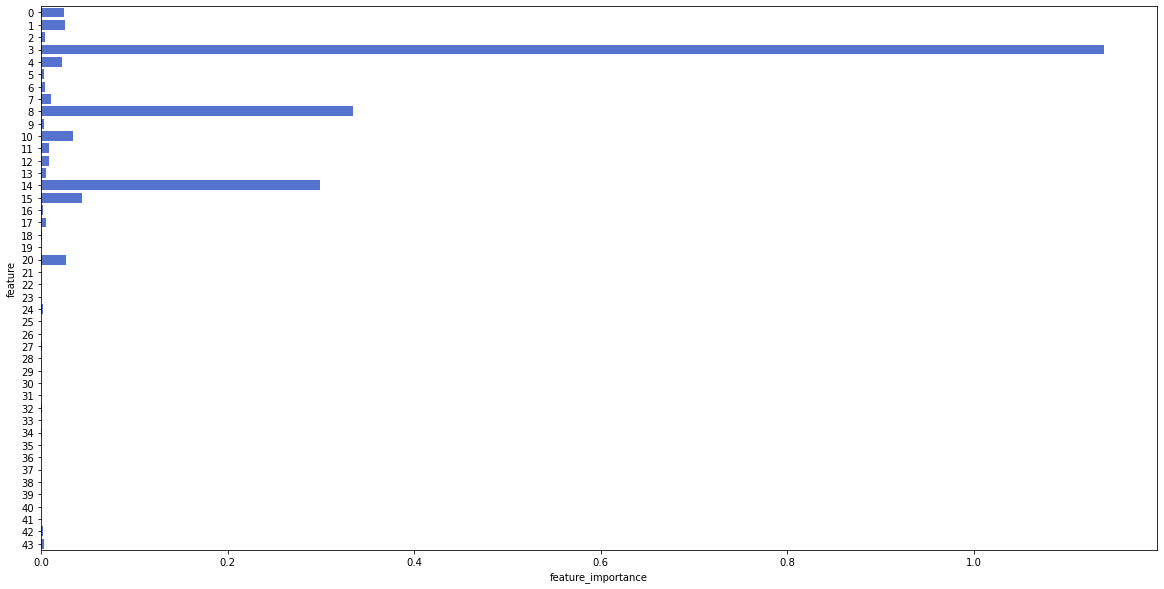

In [40]:
var_imp_plot(perm_imp_rfpimp)